In [20]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.datasets.mnist as mnist
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### 获取并处理手写数字数据集

In [21]:
train_transform = T.Compose([  # T.Compose将多个transforms的list组合起来
    T.ToTensor(),  # 将图片转换为：torch.FloatTensor
    T.Normalize([0.4914], [0.2023])  # 归一化
])

val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.4914], [0.2023])
])

train_set = mnist.MNIST("/Users/walker/mnist", train=True, transform=train_transform, download=True) # download=True
val_set = mnist.MNIST("/Users/walker/mnist", train=False, transform=val_transform, download=True)  #  # download=True

train_dataloader = DataLoader(train_set, batch_size=128, num_workers=8, shuffle=True)  # dataloader一次性创建num_worker个工作进程
val_dataloader = DataLoader(val_set, batch_size=128, num_workers=8, shuffle=False)

### 定义并使用模型

In [22]:
class ConvolutionalLayer(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride,padding,bias=False):
        super().__init__()
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=bias),
            nn.ReLU()
        )
    def forward(self,x):
        return self.cnn_layer(x)

In [23]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            ConvolutionalLayer(1, 32, 5, 1, 2),     # 28-5+4+1=28
            ConvolutionalLayer(32, 32, 5, 1, 2),    # 28
            nn.MaxPool2d(2, 2),
            ConvolutionalLayer(32, 64, 5, 1, 2),    # 14
            ConvolutionalLayer(64, 64, 5, 1, 2),    # 14
            nn.MaxPool2d(2, 2),
            ConvolutionalLayer(64, 128, 5, 1, 2),   # 7
            ConvolutionalLayer(128, 128, 5, 1, 2),  # 7
            nn.MaxPool2d(2, 2)                      # 3
        )
        self.features = nn.Linear(128*3*3,3)
        self.output = nn.Linear(3,10)               # 倒数第二层输出了维度为(Batchsize x 2)的feature向量，最后输出了维度为(Batchsize x 10)进行分类。


    def forward(self,x):
        y_conv = self.conv_layer(x)
        y_conv = torch.reshape(y_conv,[-1,128*3*3])
        y_feature = self.features(y_conv)                               # 倒数第二层输出了维度为(Batchsize x 2)的feature向量，最后输出了维度为(Batchsize x 10)进行分类。
        y_output = self.output(y_feature)      # 倒数第二层输出了维度为(Batchsize x 2)的feature向量，最后输出了维度为(Batchsize x 10)进行分类。
        return y_feature,y_output

In [24]:
model = Model()#.to("cuda:0")

### 定义损失函数

In [25]:
loss_function = nn.CrossEntropyLoss()

### 定义超参

In [26]:
glr = 1e-3
epochs = 50
num_iter_per_epoch = len(train_dataloader)
lr_schedule = {
    5: 1e-3,
    10: 1e-4,
    15: 1e-5
}

### 定义优化器

In [27]:
optimizer = torch.optim.SGD(    
    [{"params": model.parameters()},
    {"params": loss_function.parameters()}], glr, momentum=0.9)

### 开始模型训练

Epoch: 0 / 50, Loss: 2.297
data.shape (10000, 3), label.shape (10000,)


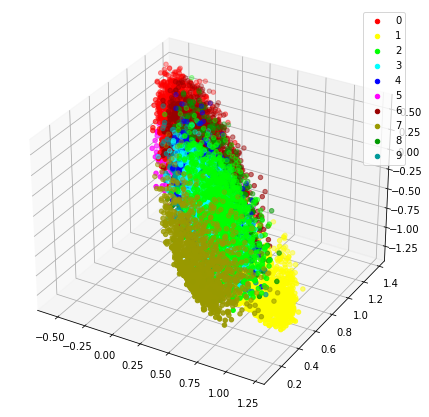

Epoch: 1 / 50, Loss: 1.300


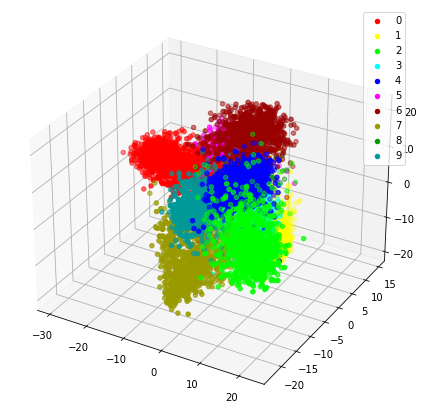

In [ ]:
for epoch in range(epochs):

    # 学习率修改策略
    if epoch in lr_schedule:
        glr = lr_schedule[epoch]
        for group in optimizer.param_groups:
            group["lr"] = glr

    mean_loss = 0
    for batch_index, (images, targets) in enumerate(train_dataloader):
        images = images#.to(device)
        targets = targets#.to(device)
        features, logits = model(images)
        loss = loss_function(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()

    mean_loss /= num_iter_per_epoch

    print(f"Epoch: {epoch} / {epochs}, Loss: {mean_loss:.3f}")
    
    with torch.no_grad():
        all_predict = []
        for batch_index, (images, targets) in enumerate(val_dataloader):
#             images = images.to(device)
#             targets = targets.to(device).float().view(-1, 1)
            images = images
            targets = targets.float().view(-1, 1)
            feature, _ = model(images)
            # 用tensor加载和求出来的全是tensor对象
            # 所以python数组all_predict里是一个个tensor
            all_predict.append(torch.cat([feature, targets], dim=1))  # [-16.3196,  78.1703, xx,   7.0000] 128 x 4
        
    # cat后变成了一个大tensor对象 （用numpy来理解也可以)
    infos = torch.cat(all_predict) # 10000 x 4
    datas = infos[:, :3].cpu().data.numpy()
    label = infos[:, 3].cpu().data.numpy()
    
    
    color = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff', '#990000', '#999900', '#009900', '#009999']
#     suplotkw = {"subplot_kw": {'projection': '3d'}}
#     fig, axs = plt.subplots(nrows=2, ncols=3, **suplotkw)
#     fig.subplots_adjust(hspace=.5, wspace=.5, top=1, right=1.5)
    
#     plt.figure(figsize=(10, 10))
#     for i in range(10):
#         plt.plot(xy[label==i, 0], xy[label==i, 1], ".", c=color[i])
#     plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc="upper right")
#     plt.show()

    ax = plt.axes(projection='3d')
    plt.subplots_adjust(left=.1, right=2, top=1.5, bottom=.1)
    for i in range(10):
        # 用每个数字设计boolean索引器把对应的坐标点全加载进来
        if epoch == 0 and i == 0:
            print(f'data.shape {datas.shape}, label.shape {label.shape}')
        data = datas[label==i]
        ax.scatter(data[:,0], data[:,1], data[:,2], '.', c=color[i])
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc="upper right")
    plt.show()